<a href="https://colab.research.google.com/github/Praveen-Web-Dev/Renewable-Dataset-Analysis/blob/main/Theme_3_4_4_6_Measurement_Challenges_and_Proxy_Indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving cleaned_dataset.csv to cleaned_dataset.csv

📌 Income-level summary of rebound proxies:
                income  countries    mean_slope  median_slope  \
0          High income         57 -16645.672903   -639.992991   
1           Low income         20    -37.760795    -31.885451   
2  Lower middle income         39   -272.005755    -75.480447   
3  Upper middle income         45 -16323.795148   -180.211010   

   mean_elasticity  median_elasticity  
0        -0.782256          -0.024354  
1        -4.617687          -4.669004  
2        -3.181154          -2.311625  
3         2.821319          -0.388375  

🏅 Top 10 countries by Rebound Slope (energy_per_capita ↑ per 1% RE):
                 country               income  obs_years  \
123         Saudi Arabia          High income         20   
128            Singapore          High income         20   
12               Belarus  Upper middle income         20   
65               Iceland          High income         20   
91        

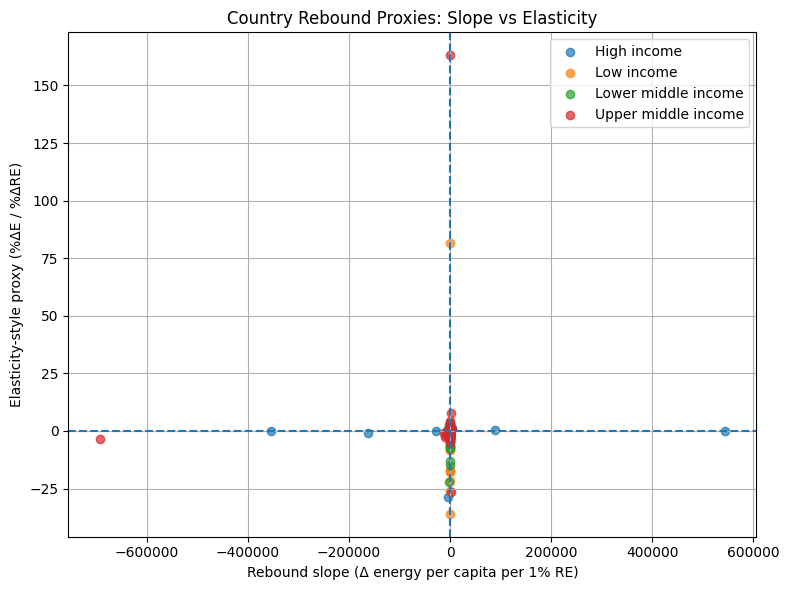

In [1]:
# ===============================
# 4.4.6 Measurement Challenges & Proxy Indicators
# ===============================

# 0) Upload dataset (Colab)
from google.colab import files
uploaded = files.upload()

# 1) Imports
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2) Load dataset
fname = [k for k in uploaded.keys()][0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))

# 3) Rename key columns for convenience
df = df.rename(columns={
    'entity': 'country',
    'income_group': 'income',
    'renewable_energy_share_in_the_total_final_energy_consumption_(%)': 'renewable_share',
    'primary_energy_consumption_per_capita_(kwh/person)': 'energy_per_capita'
})

# 4) Keep only what we need
dfp = df[['country','year','income','renewable_share','energy_per_capita']].dropna().copy()

# Remove 2020 if partial
if 2020 in dfp['year'].unique():
    dfp = dfp[dfp['year'] != 2020]

# Ensure sorted
dfp = dfp.sort_values(['country','year'])

# -------------------------------
# A) PROXY 1: Rebound Slope within each country
# For each country, regress energy_per_capita on renewable_share (simple OLS slope)
# -------------------------------
slopes = []
for c, sub in dfp.groupby('country'):
    if sub['renewable_share'].nunique() >= 2 and len(sub) >= 3:
        x = sub['renewable_share'].values
        y = sub['energy_per_capita'].values
        # simple linear regression slope using numpy polyfit
        slope = np.polyfit(x, y, 1)[0]
        slopes.append({
            'country': c,
            'obs_years': len(sub),
            'slope_energy_per_capita_per_pctRE': slope,
            'income': sub['income'].iloc[-1]
        })

slopes_df = pd.DataFrame(slopes).sort_values('slope_energy_per_capita_per_pctRE', ascending=False)

# -------------------------------
# B) PROXY 2: Elasticity-style proxy (first→last year per country)
# [%Δ energy_per_capita] / [%Δ renewable_share]
# -------------------------------
elastic_rows = []
for c, sub in dfp.groupby('country'):
    sub = sub.sort_values('year')
    if len(sub) >= 2:
        e0 = sub['energy_per_capita'].iloc[0]
        e1 = sub['energy_per_capita'].iloc[-1]
        r0 = sub['renewable_share'].iloc[0]
        r1 = sub['renewable_share'].iloc[-1]
        # % changes (avoid divide-by-zero)
        dE = None
        dR = None
        if e0 and e0 != 0:
            dE = (e1 - e0) / e0 * 100.0
        else:
            dE = np.nan
        if r0 and r0 != 0:
            dR = (r1 - r0) / r0 * 100.0
        else:
            dR = np.nan
        elasticity_proxy = dE / dR if (dR is not None and dR != 0 and not np.isnan(dR)) else np.nan
        elastic_rows.append({
            'country': c,
            'first_year': int(sub['year'].iloc[0]),
            'last_year': int(sub['year'].iloc[-1]),
            'energy_pc_first': e0,
            'energy_pc_last': e1,
            'renew_first': r0,
            'renew_last': r1,
            'pct_change_energy_pc': dE,
            'pct_change_renew': dR,
            'elasticity_proxy': elasticity_proxy,
            'income': sub['income'].iloc[-1]
        })

elastic_df = pd.DataFrame(elastic_rows)

# -------------------------------
# C) Summaries by income group
# -------------------------------
# Merge slope & elasticity on country
summary_df = pd.merge(
    slopes_df[['country','slope_energy_per_capita_per_pctRE','income']],
    elastic_df[['country','elasticity_proxy','pct_change_energy_pc','pct_change_renew','income']],
    on=['country','income'],
    how='outer'
)

# Grouped stats
income_summary = summary_df.groupby('income').agg(
    countries=('country','count'),
    mean_slope=('slope_energy_per_capita_per_pctRE','mean'),
    median_slope=('slope_energy_per_capita_per_pctRE','median'),
    mean_elasticity=('elasticity_proxy','mean'),
    median_elasticity=('elasticity_proxy','median')
).reset_index()

print("\n📌 Income-level summary of rebound proxies:")
print(income_summary)

# -------------------------------
# D) Top / Bottom countries by proxies
# -------------------------------
top_slope = slopes_df.head(10)
bottom_slope = slopes_df.tail(10)

top_elastic = elastic_df.sort_values('elasticity_proxy', ascending=False).head(10)
bottom_elastic = elastic_df.sort_values('elasticity_proxy', ascending=True).head(10)

print("\n🏅 Top 10 countries by Rebound Slope (energy_per_capita ↑ per 1% RE):")
print(top_slope[['country','income','obs_years','slope_energy_per_capita_per_pctRE']])

print("\n⬇️ Bottom 10 countries by Rebound Slope (negative/lowest):")
print(bottom_slope[['country','income','obs_years','slope_energy_per_capita_per_pctRE']])

print("\n🏅 Top 10 countries by Elasticity-style proxy (%ΔE/%ΔRE):")
print(top_elastic[['country','income','first_year','last_year','elasticity_proxy','pct_change_energy_pc','pct_change_renew']])

print("\n⬇️ Bottom 10 countries by Elasticity-style proxy (%ΔE/%ΔRE):")
print(bottom_elastic[['country','income','first_year','last_year','elasticity_proxy','pct_change_energy_pc','pct_change_renew']])

# -------------------------------
# E) Visuals: scatter of slope vs elasticity (diagnostic)
# -------------------------------
merge2 = pd.merge(
    slopes_df[['country','slope_energy_per_capita_per_pctRE']],
    elastic_df[['country','elasticity_proxy','income']],
    on='country', how='inner'
)

plt.figure(figsize=(8,6))
for grp, sub in merge2.groupby('income'):
    plt.scatter(sub['slope_energy_per_capita_per_pctRE'], sub['elasticity_proxy'], label=grp, alpha=0.7)
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.xlabel('Rebound slope (Δ energy per capita per 1% RE)')
plt.ylabel('Elasticity-style proxy (%ΔE / %ΔRE)')
plt.title('Country Rebound Proxies: Slope vs Elasticity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

